### Acknowledgement

Upon building the final model we use for the result of the competition, we consulted [TensorFlow tutorials](https://www.tensorflow.org/text/tutorials/transformer) and PyTorch tutorials with practical examples such as [Language Modeling](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) and [Language Translation](https://pytorch.org/tutorials/beginner/translation_transformer.html.)

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import math

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
"""
None

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def transform_data(np_data, bch_id):
    df = pd.DataFrame(np_data[bch_id], columns = ['x','y'])
    df['x_vel'] = np.gradient(df.x)
    df['y_vel'] = np.gradient(df.y)
    df['vel'] = np.sqrt(df.x_vel**2 + df.y_vel**2)
    df['x_acc'] = np.gradient(df.x_vel)
    df['y_acc'] = np.gradient(df.y_vel)
    df['acc'] = np.gradient(df.vel)
    tangent = np.array([1/df.vel]*2).T * np.array([df.x_vel, df.y_vel]).T
    df['curvature'] = np.abs(df.x_acc * df.y_vel - df.x_vel * df.y_acc) / (df.vel)**3
    out = df[['x', 'y', 'curvature']]
    return out.to_numpy()


def rotate(X, startpoint, endpoint, default_angle):
    
    # Find the slope of the path
    dx = X[:, endpoint, 0] - X[:, startpoint, 0]
    dy = X[:, endpoint, 1] - X[:, startpoint, 1]
    
    # Convert theta to degree in the range(0, 360)
    theta = np.arctan2(dy, dx)
    angle = np.degrees(theta)
    angle[angle < 0] += 360
    
    # Generate the degree we want to rotate by and convert back to theta
    rotate_degree = -1 * (angle - default_angle)
    rotate_theta = np.deg2rad(rotate_degree)
    
    # Reshape the array from [4, batchsize] to [batchsize, 2, 2]
    rot = np.array([np.cos(rotate_theta), -np.sin(rotate_theta),
                np.sin(rotate_theta), np.cos(rotate_theta)])
    rot = rot.T.reshape(-1, 2, 2)
    
    return rot


def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None, normalized=False):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.normalized = normalized
        self.split = split

        self.inputs, self.outputs = self.get_city_trajectories(city=city, split=split)
        
        # add shifted outputs
        if self.outputs is not None:
            self.shifted = np.roll(self.outputs, shift=1, axis=1)
            self.shifted[:, 0, :] = self.inputs[:, -1, :]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.split == 'train':
        
            data = ((self.inputs[idx], self.shifted[idx]), self.outputs[idx])

#             if self.transform:
#                 data = self.transform(data)

            return data
        
        return self.inputs[idx]
    
    def get_city_trajectories(self, city="palo-alto", split="train"):
        assert city in cities and split in splits

        # get input
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)

        # store input starting positions and rotation matrix
        start_pos = inputs[:, 0, :].copy()
        rotate_factor = rotate(inputs, 0, 29, 30)
        max_factor = inputs.max(axis=1)

        # normalize inputs (translation + rotation)
        if self.normalized:
            for i in range(len(inputs)):
                inputs[i] -= start_pos[i, :]
                
            for i in range(len(inputs)):
                inputs[i] = inputs[i] @ rotate_factor[i].T
            
            max_factor = inputs.max(axis=1)
            
#             for i in range(len(inputs)):
#                 inputs[i] = inputs[i] / max_factor[i]

        # get output
        outputs = None
        if split == "train":  # get and normalize outputs
            f_out = ROOT_PATH + split + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = np.asarray(outputs)
            if self.normalized:
                for i in range(len(inputs)):
                    outputs[i] -= start_pos[i, :]
                    
                for i in range(len(inputs)):
                    outputs[i] = outputs[i] @ rotate_factor[i].T
                
#                 for i in range(len(inputs)):
#                     outputs[i] = outputs[i] / max_factor[i]
        
            print(inputs.shape)
            print(outputs.shape)
        
            # Adding curvature as features
            if self.transform:
#                 print(inputs.shape)
#                 print(outputs.shape)
                inputs = np.array([transform_data(inputs, i) for i in range(len(inputs))])
                print(inputs.shape)

        self.start_pos = start_pos
        self.rotate_matrix = rotate_factor # np.linalg.inv(rot[i].T) to reverse back
        
        if self.normalized:
            self.n_max = max_factor

        return inputs, outputs


In [3]:
# intialize a dataset
city = 'palo-alto' 
split = 'train' #'test' #'train'
train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)

len(train_dataset)

(11993, 50, 2)
(11993, 60, 2)


11993

## Create a DataLoader class for training

In [4]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_sz, drop_last=True)
len(train_loader)

2998

In [5]:
for (inp, shift), out in train_loader:
    print(inp.shape)
    print(shift.shape)
    print(out.shape)
    for bs in range(len(inp)):
        print(len(inp[bs]))
        print(len(out[bs]))
        x = inp.detach().numpy()
        y = out.detach().numpy()
        break
    break

# # FOR TEST SET
# for inp in train_loader:
#     for bs in range(len(inp)):
#         print(inp.shape)
#         print(len(inp[bs]))
#         print(inp[0][:5])
#         break
#     break

torch.Size([4, 50, 2])
torch.Size([4, 60, 2])
torch.Size([4, 60, 2])
50
60


## Sample a batch of data and visualize 

In [6]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=.5)
    axs = axs.ravel()   
    for i in range(4):
        axs[i].xaxis.set_ticks([inp[i,0,0],
                                   inp[i,-1,0], out[i,-1,0]])
        axs[i].yaxis.set_ticks([inp[i,0,1],
                                   inp[i,-1,1], out[i,-1,1]])

        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])


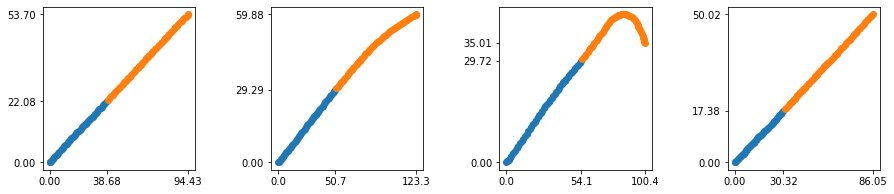

In [7]:
for i_batch, ((inp, _), out) in enumerate(train_loader):
    show_sample_batch((inp, out))
    break

## Transformer

In [8]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(DEVICE)

cuda:0


In [9]:
class TransformerTrajectory(nn.Module):
    def __init__(
        self,
        batch_size,
        model_dim, 
        n_heads=8, 
        linear_dim=1024,
        dropout_rate=0.1, 
        encoder_layers=1, 
        decoder_layers=1,
        input_dim=2,
        teacher_ratio=0.3
    ):
        super(TransformerTrajectory, self).__init__()
        self.batch_size = batch_size
        self.model_dim = model_dim
        self.n_heads = n_heads
        self.linear_dim = linear_dim
        self.dropout_rate = dropout_rate
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.input_dim = input_dim
        self.input_length = 50
        self.output_length = 60
        self.teacher_ratio = teacher_ratio
        
        # input linear embedding
        self.input_projection = nn.Linear(input_dim, model_dim)
        
        # encoder
        encoder = nn.TransformerEncoderLayer(
            d_model=model_dim, 
            nhead=n_heads, 
            dim_feedforward=linear_dim, 
            dropout=dropout_rate, 
            batch_first=True,
            device=DEVICE
        )
        self.encoder = nn.TransformerEncoder(encoder, num_layers=encoder_layers, norm=None)
        
        # bridge
        self.cell_bridge = nn.Sequential(
            nn.Linear(self.input_length * model_dim, linear_dim),
            nn.LeakyReLU(),
            nn.Linear(linear_dim, linear_dim),
            nn.LeakyReLU(),
            nn.Linear(linear_dim, model_dim)
        )    
        self.hidden_bridge = nn.Sequential(
            nn.Linear(self.input_length * model_dim, linear_dim),
            nn.LeakyReLU(),
            nn.Linear(linear_dim, linear_dim),
            nn.LeakyReLU(),
            nn.Linear(linear_dim, model_dim)
        )
        
        # decoder
        self.decoder = nn.LSTM(
            input_size=model_dim, 
            hidden_size=model_dim,
            batch_first=True,
            num_layers=decoder_layers
        )
        
        # final linear layer
        self.output_projection = nn.Linear(model_dim, input_dim)
    
    def get_angles(self, pos, i, D):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
        return pos * angle_rates


    def positional_encoding(self, D, position=110, dim=3, device=DEVICE):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                np.arange(D)[np.newaxis, :],
                                D)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        if dim == 3:
            pos_encoding = angle_rads[np.newaxis, ...]
        elif dim == 4:
            pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
        return torch.tensor(pos_encoding, device=device)
    
    def generate_square_subsequent_mask(self, size):
        return torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
    
    def forward(self, inputs, ground_truth=None, device=DEVICE):
        # transformer encoder
        proj_inputs = self.input_projection(inputs)
        proj_inputs += self.positional_encoding(self.model_dim)[:, :self.input_length, :]
        
        memory = self.encoder(proj_inputs)
        
        # bridge
        memory = memory.reshape(self.batch_size, -1)
        lstm_cell = self.cell_bridge(memory).unsqueeze(0)
        lstm_hidden = self.hidden_bridge(memory).unsqueeze(0)
        
        # LSTM decoder
        if ground_truth is not None:
            ground_truth = self.input_projection(ground_truth)
            
        outputs = torch.zeros(self.batch_size, self.output_length, 2).to(device)
        lstm_out = self.input_projection(inputs[:, -1:, :])
        
        for t in range(self.output_length):    
            lstm_out, (lstm_hidden, lstm_cell) = self.decoder(lstm_out, (lstm_hidden, lstm_cell))
            outputs[:, t] = self.output_projection(lstm_out).squeeze(1)
            
            # DECIDER: TEACHER FORCING GROUND TRUTH
            if (ground_truth is not None) and random.random() < self.teacher_ratio:
                lstm_out = ground_truth[:, t:t+1, :]
        
        return outputs

## Train the Transformer

In [10]:
def train(
    batch_size, 
    city, 
    model_dim,
    n_heads,
    linear_dim,
    dropout_rate,
    encoder_layers,
    decoder_layers,
    num_iters,
    learning_rate,
    factor,
    patience,
    teacher_ratio,
    device=DEVICE
):
    # Create the training/validation set
    train_dataset = ArgoverseDataset(city=city, split='train', transform=False, normalized=True)
    train_sz = int(len(train_dataset) * 0.9)
    val_sz = len(train_dataset) - train_sz
    train_loader, val_loader = torch.utils.data.random_split(train_dataset, [train_sz, val_sz])
    train_loader = DataLoader(train_loader, batch_size=batch_size, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_loader, batch_size=batch_size, drop_last=True, shuffle=False)
    
    # Initialize the transformer/optimizer/loss function
    transformer = TransformerTrajectory(
        batch_size=batch_size,
        model_dim=model_dim, 
        n_heads=n_heads, 
        linear_dim=linear_dim, 
        dropout_rate=dropout_rate, 
        encoder_layers=encoder_layers, 
        decoder_layers=decoder_layers,
        teacher_ratio=teacher_ratio
    ).to(device)

    optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate) 
    loss_function = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True) 
    
    # Print out how many parameters to train
    param_sizes = [p.numel() for p in transformer.parameters()]
    print(f"number of weight/biases matrices: {len(param_sizes)} "
          f"for a total of {np.sum(param_sizes)} parameters ")
    
    avg_train_loss, avg_val_loss_teachers, avg_val_loss_auto = [], [], []
    train_time, elapsed_time = [], []
    best_val_score = float('inf')
    
    # Start training
    for epoch in tqdm(list(range(num_iters))):
        print(f'Epoch {epoch+1}')
        print('Training & Validating ', end='')
        
        start_time = time.time()
        train_loss, val_loss_teachers, val_loss_auto = [], [], []
        
        # Training set
        for batches, ((X_enc, X_dec), y) in enumerate(train_loader):
            X_enc = X_enc.to(device).float()
            X_dec = X_dec.to(device).float()
            y = y.to(device).float()
            
            # Track progress
            if (batches + 1) % 20 == 0:
                print('-', end='')
            
            # Forward pass
            optimizer.zero_grad()
            out = transformer(X_enc, ground_truth=y)
            
            # Backpropagation
            loss = loss_function(out, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        print()
        avg_train = np.mean(train_loss)
        avg_train_loss.append(avg_train)
        
        # End the time
        end_train_time = time.time()
        train_time.append(end_train_time - start_time)
        
        # Evaluate on val set
        with torch.no_grad():
            for batches, ((X_enc, X_dec), y) in enumerate(val_loader):
                X_enc = X_enc.to(device).float()
                X_dec = X_dec.to(device).float()
                y = y.to(device).float()
                
                out_teachers = transformer(X_enc, ground_truth=y)               
                loss_teachers = loss_function(out_teachers, y)
                val_loss_teachers.append(loss_teachers.item())
                
                out_auto = transformer(X_enc)
                loss_auto = loss_function(out_auto, y)
                val_loss_auto.append(loss_auto.item())
                
            avg_val_teachers = np.mean(val_loss_teachers)
            avg_val_loss_teachers.append(avg_val_teachers)
            avg_val_auto = np.mean(val_loss_auto)
            avg_val_loss_auto.append(avg_val_auto)
        
        end_time = time.time()
        elapsed_time.append(end_time - start_time)

        print(f'- Training Loss: {avg_train}')
        print(f'- Teachers Validation Loss: {avg_val_teachers}')
        print(f'- Auto Validation Loss: {avg_val_auto}')
        print(f'- Train Time: {sum(train_time)}\n- Elapsed Time: {sum(elapsed_time)}\n')
        
        scheduler.step(avg_val_auto)
        
        # save better model
        if avg_val_auto < best_val_score:
            best_val_score = avg_val_auto
            torch.save(transformer, f'best_{city}_auto.pt')
        
    return transformer, (avg_train_loss, avg_val_loss_auto)

In [12]:
def plot_loss(start_from, city, split, losses):

    avg_train_loss, avg_val_loss_teachers, avg_val_loss_auto = losses
    plt.plot(np.sqrt(avg_train_loss[start_from:]), label='train_loss')
    plt.plot(np.sqrt(avg_val_loss_teachers[start_from:]), label='validation_loss_teachers')
    plt.plot(np.sqrt(avg_val_loss_auto[start_from:]), label='validation_loss_auto')
    plt.title(f'{city} RMSE {split} Loss vs. Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [13]:
def vis_results(city, split, batch_size, model, idx, device=DEVICE):
    train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
#     model.cpu()
#     model.pos_encoding.to('cpu')
#     print(model.pos_encoding.get_device())
    
    with torch.no_grad():
        for (X_enc, X_dec), y in train_loader:
            X_enc = X_enc.to(device).float()
            X_dec = X_dec.to(device).float()
            y = y.to(device).float()

            out_auto = model(X_enc)
            out_teachers = model(X_enc, ground_truth=y)
            break
#     print(X_enc[idx])
#     print(out_auto[idx])
    
#     print(X_enc.shape, X_dec.shape, y.shape, out_auto.shape)
    X = X_enc.cpu()
    y = y.cpu()
    out_auto = out_auto.cpu()
    out_teachers = out_teachers.cpu()
    
    x_jump = train_dataset.start_pos[idx, 0]
    y_jump = train_dataset.start_pos[idx, 0]
    rot = train_dataset.rotate_matrix[idx].T
    X = X[idx] @ np.linalg.inv(rot) + train_dataset.start_pos[idx]
    y = y[idx] @ np.linalg.inv(rot) + train_dataset.start_pos[idx]
    out_auto = out_auto[idx] @ np.linalg.inv(rot) + train_dataset.start_pos[idx]
    out_teachers = out_teachers[idx] @ np.linalg.inv(rot) + train_dataset.start_pos[idx]
    
    plt.scatter(X[:, 0], X[:, 1], label='seed')
    plt.scatter(y[:, 0], y[:, 1], label='ground truth')
    plt.scatter(out_auto[:, 0], out_auto[:, 1], label='prediction auto')
    plt.scatter(out_teachers[:, 0], out_teachers[:, 1], label='prediction teachers')
    plt.title(f'Random Sample From {city}_{split} Projectile Visualization')
    plt.legend()
    plt.show()
        

In [133]:
def vis_test(city, split, batch_sz, model, idx, norm_viz=True):
    '''
    This is the last batch, which is usually not complete and need to fill with 0s.
    Check if I convert the prediction back correctly or not
    '''
    
    # Create the dataset for testing
    test_dataset = ArgoverseDataset(city = city, split = split,
                                    transform=False, normalized=True)
        
    test_loader = DataLoader(test_dataset, batch_size=batch_sz)
    
    with torch.no_grad():
        for X in test_loader:
            if len(X) == batch_sz:
                continue
            print(len(X))
            to_fill = np.zeros([batch_sz-len(X), 50, 2])
            X = torch.from_numpy(np.append(X, to_fill, axis=0)).float()
            X = X.to(device).float()
            S = X.shape[1]
            mask = create_look_ahead_mask(S)

            output = model(X, mask)[0].reshape(batch_size, -1, 2)

            X = X.cpu()
            output = output.cpu()

            if norm_viz:
                plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
                plt.scatter(output[idx, :, 0], output[idx, :, 1], label='pred')
                plt.legend()
                plt.show()
            else:
                rotation =  test_dataset.rotate_matrix[-1].T
                X[idx] = X[idx] @ np.linalg.inv(rotation)
                X[idx] = X[idx] + test_dataset.start_pos[-1, : ]
                output[idx] = output[idx] @ np.linalg.inv(rotation)
                output[idx] = output[idx] + test_dataset.start_pos[-1, : ]

                plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
                plt.scatter(output[idx, :, 0], output[idx, :, 1], label='pred')
                plt.legend()
                plt.show()
    

In [142]:
def make_pred(test_loader, batch_sz, model):
    '''
    Remember to use test_dataset stats, NOT train_dataset
    '''
    count_row = 0
    out = []

    for X in test_loader:
        if len(X) != batch_sz:
            print(len(X))
            to_fill = np.zeros([batch_sz-len(X), 50, 2])
            X = torch.from_numpy(np.append(X, to_fill, axis=0))
            
#             a = test_dataset.rotate_matrix[-1].T
#             temp = X[20]@np.linalg.inv(a) + test_dataset.start_pos[-1]
#             plt.scatter(temp[:, 0], temp[:, 1], label='input')

        X = X.to(device).float()
    
        S = X.shape[1]
        mask = create_look_ahead_mask(S)

        pred = model(X, mask)[0].reshape(batch_size, -1, 2).cpu().detach().numpy()

        for i in range(batch_sz):
            if count_row >= len(test_dataset):
                break
                
#             if count_row == (len(test_dataset) - 1):
#                 plt.scatter(X[i, :, 0], X[i, :, 1], label='input')
#                 plt.scatter(pred[i, :, 0], pred[i, :, 1], label='pred')
#                 plt.legend()
#                 plt.show()

            rotation =  test_dataset.rotate_matrix[count_row].T
            pred[i] = pred[i] @ np.linalg.inv(rotation)
            pred[i] = pred[i] + test_dataset.start_pos[count_row, : ]

    #         print(pred[i, 0, :])
                
            out.append(pred[i])
            count_row += 1 
            
    #         print(count_row)
    #         print(pred[0, :5, :])

    out = np.array(out).reshape(len(test_dataset), -1)

    return out


### Pittsburgh

In [11]:
# Hyperparameter
batch_size = 32
city = 'pittsburgh'
model_dim = 64
n_heads = 8
linear_dim = 64 # [32, 128]
dropout_rate = 0 # [0, 0.5]
encoder_layers = 4
decoder_layers = 1
num_iters = 60 # [50, 100]
learning_rate = 0.002 # [0.001, 0.005]
factor = 0.5 # 0.1 ~ 0.99
patience = 3
teacher_ratio = 0.02

pitts_net, pitts_loss = train(
    batch_size, 
    city, 
    model_dim,
    n_heads,
    linear_dim,
    dropout_rate,
    encoder_layers,
    decoder_layers,
    num_iters,
    learning_rate,
    factor,
    patience,
    teacher_ratio,
    device=DEVICE
)

(43544, 50, 2)
(43544, 60, 2)
number of weight/biases matrices: 68 for a total of 560834 parameters 


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1
Training & Validating ------------------------------------------------------------------------------------------------------------- Training Loss: 103.6516999699711
- Teachers Validation Loss: 95.42486920076259
- Auto Validation Loss: 96.46355174569523
- Train Time: 384.1564929485321
- Elapsed Time: 399.8114449977875

Epoch 4
Training & Validating -------------------------------------------------------------
- Training Loss: 98.39263149647931
- Teachers Validation Loss: 95.87858887279735
- Auto Validation Loss: 97.43501438814052
- Train Time: 515.0228810310364
- Elapsed Time: 535.5945045948029

Epoch 5
Training & Validating -------------------------------------------------------------
- Training Loss: 86.08113981539907
- Teachers Validation Loss: 83.52708670672249
- Auto Validation Loss: 96.7853531556971
- Train Time: 644.2324688434601
- Elapsed Time: 669.8426465988159

Epoch 6
Training & Validating -------------------------------------------------------------
- Training Loss: 

(43544, 50, 2)
(43544, 60, 2)


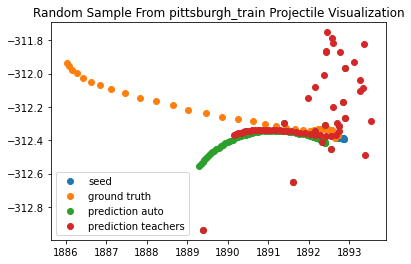

In [18]:
vis_results('pittsburgh', 'train', 32, pitts_net, 20)